# Graphs for params sensitivity in paper

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [6]:
import sys
sys.path.append('../')

In [7]:
import neptune

In [8]:
def convert_to_dataset_name(target_app: str, middleware: bool, manually_selected: bool) -> str:
    match target_app, middleware, manually_selected:
        case "sock-shop", _, True:
            return "SS-small"
        case "sock-shop", False, False:
            return "SS-medium"
        case "sock-shop", True, False:
            return "SS-large"
        case "train-ticket", _, True:
            return "TT-small"
        case "train-ticket", False, False:
            return "TT-medium"
        case "train-ticket", True, False:
            return "TT-large"
        case _:
            raise ValueError(f"Unknown combination: {target_app}, {middleware}, {manually_selected}")

In [9]:
## download from neptune
TSDR_START_ID, TSDR_END_ID = 1374, 1448
TSDR_SKIP_IDS = []
TSDR_RUN_IDS = [f"TSDR-{i}" for i in range(TSDR_START_ID, TSDR_END_ID + 1) if i not in TSDR_SKIP_IDS]

In [20]:
import neptune.exceptions

def fetch_metadata_of_tsdr(run_id: str) -> dict[str, str|float]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return {}
        try:
            dataset = run["dataset"].fetch()
            target_app = dataset["target_app"]
            middleware = dataset["metric_types"]["middlewares"]
            manually_selected = dataset["use_manually_selected_metrics"]
        except neptune.exceptions.MissingFieldException: 
            return {}

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type
        
        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (True, True, _, "changepoint-kde", _):
                reduction = "MetricSifter"
            case (_, _, _, _, _):
                print(f"Unknown reduction method: RUN_ID {run_id}, {tsdr_params}")
                return {}
        
        cost_model = tsdr_params["step1_changepoint_cost_model"]
        penalty = tsdr_params["step1_changepoint_penalty"]
        search_method = tsdr_params["step1_changepoint_search_method"]
        granularity = tsdr_params["step2_clustering_granularity"]
        kde_bandwidth = tsdr_params["step2_changepoint_kde_bandwidth"]
        kde_bandwidth_adjust = tsdr_params["step2_changepoint_kde_bandwidth_adjust"]

        try:
            scores = run["scores"].fetch()
        except neptune.exceptions.MissingFieldException as e: 
            print(f"Missing scores: RUN_ID {run_id}")
            return {}

        frr = scores["reduction_rate_mean"]
        rfr = scores["cause_metrics"]["recall_mandatory_mean"]
        rfp = scores["cause_metrics"]["proportion_mandatory_mean"]
        num_series = tuple([int (s) for s in scores["num_series"]["total"].split("/")])
        num_found_cause_metrics = scores["cause_metrics"]["num_mandatory_found_mean"]
        elapsed_time = scores["elapsed_time_min"]
        return {
            "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
            "FRR": frr, "RFR": rfr, "RFP": rfp, "elapsed_time": elapsed_time,
            "num_metrics(reduced)": num_series[0],
            "num_metrics(filtered)": num_series[1],
            "num_metrics(raw)": num_series[2],
            "num_found_cause_metrics": num_found_cause_metrics,
            "rs_ac@2": scores["RS_AC_2"], "rs_ac@5": scores["RS_AC_5"], "rs_avg@5": scores["RS_AVG_5"],
            "cost_model": cost_model, "penalty": penalty, "search_method": search_method,
            "granularity": granularity, "kde_bandwidth": kde_bandwidth, "kde_bandwidth_adjust": kde_bandwidth_adjust,
        }

In [21]:
import joblib 

tsdr_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_metadata_of_tsdr)(run) for run in TSDR_RUN_IDS)
assert tsdr_items is not None
tsdr_items = [item for item in tsdr_items if item]
assert len(tsdr_items) <= len(TSDR_RUN_IDS), f"{len(tsdr_items)} > {len(TSDR_RUN_IDS)}"

https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1376
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1374
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1377
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1378
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1375
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1380
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1381
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1384
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1382
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1386
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1383
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1397
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1387
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1393
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1388
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1389
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1392
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1396
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1379
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1390
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-1395
https://app.neptune.ai/yuuk1/tsdr/

In [31]:
columns = ["FRR", "RFR", "RFP", "elapsed_time", "rs_ac@2", "rs_ac@5", "rs_avg@5"]
indexs = ["dataset", "cost_model", "penalty", "search_method", "kde_bandwidth", "kde_bandwidth_adjust"]
tsdr_results_df = pd.DataFrame(tsdr_items)
tsdr_results_df.drop_duplicates(subset=indexs, keep="last", inplace=True)
tsdr_results_df = tsdr_results_df.set_index(indexs).sort_index()
tsdr_results_df

FRR  \
dataset   cost_model penalty search_method kde_bandwidth kde_bandwidth_adjust             
SS-medium l2         bic     binseg        scott         0.01                  0.474613   
                                                         0.02                  0.489614   
                                                         0.04                  0.483589   
                                                         0.06                  0.473579   
                                                         0.08                  0.467818   
                             bottomup      scott         0.01                  0.504365   
                                                         0.02                  0.520063   
                                                         0.04                  0.506026   
                                                         0.06                  0.452999   
                                                         0.08                  0.430145   
                             pelt          scott         0.01                  0.460905   
                                                         0.02                  0.474176   
                                                         0.04                  0.449275   
                                                         0.06                  0.431478   
                                                         0.08                  0.420480   
SS-small  l2         aic     binseg        scott         0.01                  0.249478   
                                                         0.02                  0.256087   
                                                         0.04                  0.218931   
                                                         0.06                  0.192384   
                                                         0.08                  0.172536   
                                                         0.10                  0.158098   
                                                         0.50                  0.073416   
                                                         1.00                  0.041575   
                             pelt          scott         0.01                  0.189710   
                                                         0.02                  0.197664   
                                                         0.04                  0.156261   
                                                         0.06                  0.126415   
                                                         0.08                  0.103992   
                                                         0.10                  0.089976   
                                                         0.50                  0.029018   
                                                         1.00                  0.013699   
                     bic     binseg        scott         0.01                  0.317569   
                                                         0.02                  0.342527   
                                                         0.04                  0.359150   
                                                         0.06                  0.362403   
                                                         0.08                  0.363357   
                                                         0.10                  0.362858   
                                                         0.50                  0.330172   
                                                         1.00                  0.283618   
                             bottomup      scott         0.01                  0.348304   
                                                         0.02                  0.391755   
                                                         0.04                  0.380228   
                                                         0.06                  0

/tmp/ipykernel_1084006/559694501.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_df = plot_df[plot_df["dataset"] == "SS-small"][plot_df["penalty"] == "bic"][plot_df["search_method"] == "bottomup"]
/tmp/ipykernel_1084006/559694501.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_df = plot_df[plot_df["dataset"] == "SS-small"][plot_df["penalty"] == "bic"][plot_df["search_method"] == "bottomup"]


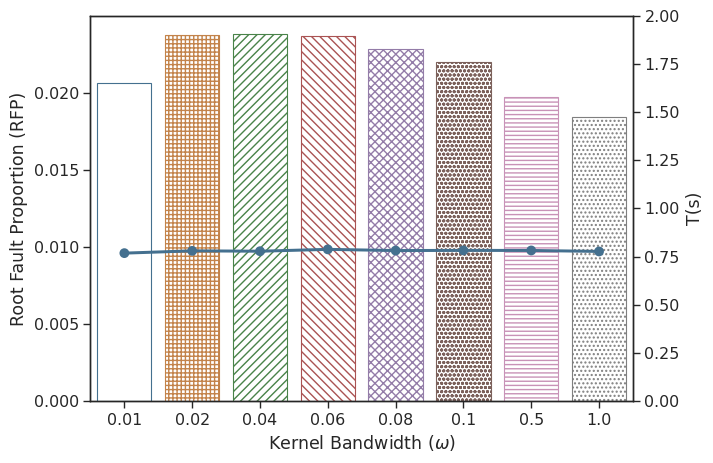

In [49]:
from itertools import cycle

plot_df = tsdr_results_df.reset_index()
# plot_df["combination"] = "(" + plot_df["search_method"] + "," + plot_df["cost_model"] + "," + plot_df["penalty"].astype(str) + ")"

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.3)
sns.set_palette("tab10", 8, 0.5)
data_df = plot_df[plot_df["dataset"] == "SS-small"][plot_df["penalty"] == "bic"][plot_df["search_method"] == "bottomup"]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax2 = ax.twinx()

bar = sns.barplot(
    data=data_df, x="kde_bandwidth_adjust", y="RFP",# hue="combination",
    alpha=1, color="none", fill=None, 
    ax=ax,
)
# num_bar = 5
edge_colors = sum(map(lambda c: [c] * num_bar, sns.color_palette()), [])
# https://stackoverflow.com/questions/76233164/how-to-add-hatches-to-histplot-bars-and-legend
hatchs = ["","++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"]#[0:num_bar]
# for container, hatch, handle, color in zip(ax.containers, hatchs, ax.get_legend().legend_handles, sns.color_palette()):
for patch, hatch, color in zip(bar.patches, hatchs, sns.color_palette()):
    patch.set_hatch(hatch)
    patch.set_edgecolor(color)
#     handle.set_hatch(hatch)
#     handle.set_edgecolor(color)
#     for rectangle in container:
#         rectangle.set_hatch(hatch)
#         rectangle.set_edgecolor(color)

markers = ["o", "s", "D", "v", "^", "P", "X", "p", "d"]
sns.pointplot(
    data=data_df, x="kde_bandwidth_adjust", y="elapsed_time",# hue="combination",
    # order=[], hue_order=[],
    dodge=0.5,
    markers=markers, linestyles=["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"],
    ax=ax2,
)


ax.set_xlabel("Kernel Bandwidth Weight ($\omega$)")
ax.set_ylabel("Root Fault Proportion (RFP)")
ax2.set_ylabel("T(s)")
ax2.set_ylim(0, 2.0)
# ax2.get_legend().remove()
# sns.move_legend(
#     ax, "lower center",
#     bbox_to_anchor=(.5, 1), ncol=3, title="Parameter Set (search, cost, penalty)", frameon=False,
# )
fig.savefig(f"materials/plot_tsdr_params_sensitivity_SS-small_RFP.pdf", format="pdf", bbox_inches="tight")

plt.show()
fig.clf()
plt.close(fig=fig)

In [39]:
fig.clf()
plt.close(fig=fig)
plt.close("all")

## Localization

In [40]:
## download from neptune
LOC_TSDR_START_ID, LOC_TSDR_END_ID = 1374, 1448
LOC_TSDR_SKIP_IDS = []
LOC_TSDR_RUN_IDS = [f"TSDRLOC-{i}" for i in range(LOC_TSDR_START_ID, LOC_TSDR_END_ID + 1) if i not in LOC_TSDR_SKIP_IDS]